<a href="https://colab.research.google.com/github/tanziljain/Depression-Detection-System-Using-Machine-Learning-/blob/main/DEPRESION_DETECTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the specific path we're looking for
target_path = '/content/drive/MyDrive/Motion_Activity/'

print("Looking for motion activity data...\n")

# Check if the target path exists
if os.path.exists(target_path):
    print(f"Found Motion_Activity folder at: {target_path}")

    # List contents of Motion_Activity
    print("\nContents of Motion_Activity folder:")
    try:
        items = os.listdir(target_path)
        if items:
            for item in items:
                item_path = os.path.join(target_path, item)
                if os.path.isdir(item_path):
                    print(f"  {item}/")
                    # List CSV files in subdirectories
                    sub_items = os.listdir(item_path)
                    csv_files = [f for f in sub_items if f.endswith('.csv')]
                    if csv_files:
                        print(f"    Contains {len(csv_files)} CSV files")
                    else:
                        print(f"    No CSV files found")
                else:
                    print(f"  {item}")
        else:
            print("  (Empty folder)")
    except Exception as e:
        print(f"Could not read folder contents: {e}")

    # Check specifically for data folder
    data_path = os.path.join(target_path, 'data')
    if os.path.exists(data_path):
        print(f"\n Found 'data' subfolder:")
        try:
            data_items = os.listdir(data_path)
            for item in data_items:
                full_path = os.path.join(data_path, item)
                if os.path.isdir(full_path):
                    # Count CSV files in condition and control folders
                    csv_count = 0
                    if os.path.exists(full_path):
                        for file in os.listdir(full_path):
                            if file.endswith('.csv'):
                                csv_count += 1
                    print(f"   {item}/ - {csv_count} CSV files")
        except Exception as e:
            print(f"  Could not read data folder: {e}")
else:
    print(f"Motion_Activity folder not found at: {target_path}")
    print("\nSuggested alternatives found:")

    # Only search for relevant folders in base directory
    base_path = '/content/drive/MyDrive/'
    try:
        top_items = os.listdir(base_path)
        relevant_folders = []

        for item in top_items:
            item_path = os.path.join(base_path, item)
            if os.path.isdir(item_path):
                # Check for folders that might contain motion data
                if any(keyword in item.lower() for keyword in ['motion', 'activity', 'sensor', 'data', 'depression']):
                    relevant_folders.append(item)

        if relevant_folders:
            for folder in relevant_folders[:5]:  # Limit to 5 to avoid too much output
                print(f"  {folder}/ (might contain motion data)")
        else:
            print("  No motion/data-related folders found in MyDrive")

    except Exception as e:
        print(f"  Error searching for folders: {e}")

print("\n" + "="*50)
print("To use this project, ensure your data is in:")
print("/content/drive/MyDrive/Motion_Activity/data/")
print("With subfolders: condition/ and control/")
print("="*50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking for motion activity data...

Found Motion_Activity folder at: /content/drive/MyDrive/Motion_Activity/

Contents of Motion_Activity folder:
  control/
    Contains 32 CSV files
  condition/
    Contains 23 CSV files
  scores.csv
  .DS_Store

To use this project, ensure your data is in:
/content/drive/MyDrive/Motion_Activity/data/
With subfolders: condition/ and control/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Cell 2: Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from sklearn import model_selection

# TensorFlow/Keras imports for LSTM
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.base import BaseEstimator, TransformerMixin

In [29]:
# Cell 3: Combine data function
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []
    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(os.path.join(path, filepath), parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)
    return combine_df

In [32]:
# Cell 4: Process condition data
combine_df = combine_data('/content/drive/MyDrive/Motion_Activity/condition')

conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

In [33]:
# Cell 5: Process control data
combine_df = combine_data('/content/drive/MyDrive/Motion_Activity/control')

controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

In [8]:
# Cell 6: Feature extraction functions
def nextday(dates):
    for date in dates:
        yield date

def zero_count(series):
    return list(series).count(0)

def extractfeatures(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': zero_count(X[mask]['log_activity'])
    }
    return d

In [30]:
# Cell 7: ExtractData Transformer
class ExtractData(BaseEstimator, TransformerMixin):
    def __init__(self, path):
        self.path = path
        self.X = []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        dirs = os.listdir(self.path)

        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(os.path.join(self.path, filepath))
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()

                for date in nextday(dates):
                    d = extractfeatures(X, date)
                    d['source'] = condition
                    self.X.append(d)

        return pd.DataFrame(self.X)

In [39]:
# Cell 8: Extract features for both groups
# Extract condition features
e = ExtractData(path='/content/drive/MyDrive/Motion_Activity/condition')
conditions = e.fit_transform(X=None, y=None)
conditions['state'] = 1

# Extract control features
e = ExtractData(path='/content/drive/MyDrive/Motion_Activity/control')
controls = e.fit_transform(X=None, y=None)
controls['state'] = 0

# Combine into full dataset
full_df = pd.concat([controls, conditions], ignore_index=True)
print(f"Dataset shape: {full_df.shape}")
print(full_df.head())

Dataset shape: (1144, 7)
   mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
0           3.841528          2.420923               0.0          7.305860   
1           2.814061          2.673746               0.0          7.243513   
2           3.245236          2.751031               0.0          7.243513   
3           2.869248          2.742636               0.0          7.336937   
4           3.412404          2.629478               0.0          7.647309   

   zero_proportion_activity      source  state  
0                       191  control_12      0  
1                       612  control_12      0  
2                       532  control_12      0  
3                       611  control_12      0  
4                       460  control_12      0  


In [35]:
# Cell 9: Custom train-test split function
def custom_train_test_split(train_set, test_set):
    X_train = train_set.drop('label', axis=1)
    y_train = train_set.label
    X_test = test_set.drop('label', axis=1)
    y_test = test_set.label
    return X_train, X_test, y_train, y_test

In [36]:
# Cell 10: Custom Cross-Validation Classifier
class CustomClassifierCV(BaseEstimator, TransformerMixin):
    def __init__(self, base_clf):
        self.base_clf = base_clf
        self.predictions = []
        self.actuals = []

    def fit(self, X, y=None):
        X['label'] = y
        participants = X.source.unique()
        folds = []

        for p in participants:
            folds.append(X[X['source'] == p])

        for i in range(len(folds)):
            test_set = folds[i]
            train_fold = [elem for idx, elem in enumerate(folds) if idx != i]
            train_set = pd.concat(train_fold)
            X_train, X_test, y_train, y_test = custom_train_test_split(
                train_set.drop(['source'], axis=1),
                test_set.drop(['source'], axis=1)
            )

            self.base_clf.fit(X_train, y_train)
            pred = self.predict(X_test)
            self.predictions.append(pred)
            self.actuals.append(test_set.label.iloc[0])

        return self

    def predict(self, X):
        predictions = self.base_clf.predict(X)
        ones = predictions.tolist().count(1)
        zeroes = predictions.tolist().count(0)
        return 1 if ones > zeroes else 0

    def score(self):
        print(classification_report(self.predictions, self.actuals))

In [47]:
# Cell 11: Prepare data for models
X = full_df.drop(['state', 'source'], axis=1)
y = full_df.state

# Split for standard models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (915, 5)
Test set size: (229, 5)


In [41]:
# Cell 12: Train individual models
print("Training Random Forest...")
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
rf_pred = forest.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

print("\nTraining KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print(f"KNN Accuracy: {knn_acc:.4f}")

print("\nTraining XGBoost...")
xgb_classifier = xgboost.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)
xgb_pred = xgb_classifier.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

Training Random Forest...
Random Forest Accuracy: 0.7467

Training KNN...
KNN Accuracy: 0.6769

Training XGBoost...
XGBoost Accuracy: 0.7293


In [42]:
# Cell 13: Ensemble Model (Voting Classifier)
print("\nTraining Ensemble (Voting Classifier)...")
estimators = [
    ("forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("knn", KNeighborsClassifier(n_neighbors=5)),
    ("xgb", xgboost.XGBClassifier(random_state=42))
]

ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)
ensemble_acc = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble Accuracy: {ensemble_acc:.4f}")

# Cross-validation score
results = model_selection.cross_val_score(ensemble, X, y, cv=5)
print(f"Cross-validation scores: {results}")
print(f"Mean CV Accuracy: {results.mean():.4f}")


Training Ensemble (Voting Classifier)...
Ensemble Accuracy: 0.7380
Cross-validation scores: [0.64628821 0.66375546 0.68995633 0.69432314 0.69736842]
Mean CV Accuracy: 0.6783


In [43]:
# Cell 14: LSTM Model for Time Series
print("\nTraining LSTM Model...")
# Reshape data for LSTM
X_lstm = X.values.reshape((X.shape[0], 1, X.shape[1]))
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y, test_size=0.2, random_state=42, stratify=y
)

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(1, X_train_lstm.shape[2])))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    batch_size=32,
    epochs=15,
    verbose=1
)

# Evaluate LSTM
lstm_loss, lstm_acc = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print(f"LSTM Test Accuracy: {lstm_acc:.4f}")


Training LSTM Model...
Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.6179 - loss: 0.6679 - val_accuracy: 0.6463 - val_loss: 0.6458
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6608 - loss: 0.6402 - val_accuracy: 0.6463 - val_loss: 0.6381
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6447 - loss: 0.6419 - val_accuracy: 0.6507 - val_loss: 0.6349
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6654 - loss: 0.6383 - val_accuracy: 0.6507 - val_loss: 0.6366
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6533 - loss: 0.6397 - val_accuracy: 0.6550 - val_loss: 0.6278
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6481 - loss: 0.6352 - val_accuracy: 0.6550 - val_loss: 0.6263
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6617 - loss: 0.6304 - val_accuracy: 0.6507 - val_loss: 0.6235
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6494 - loss: 0.6376 - 


=== FEATURE IMPORTANCE ===

Top 5 Most Important Features:
                    feature  importance
1          std_log_activity    0.263342
0         mean_log_activity    0.256526
4  zero_proportion_activity    0.227788
3          max_log_activity    0.224014
2          min_log_activity    0.028331


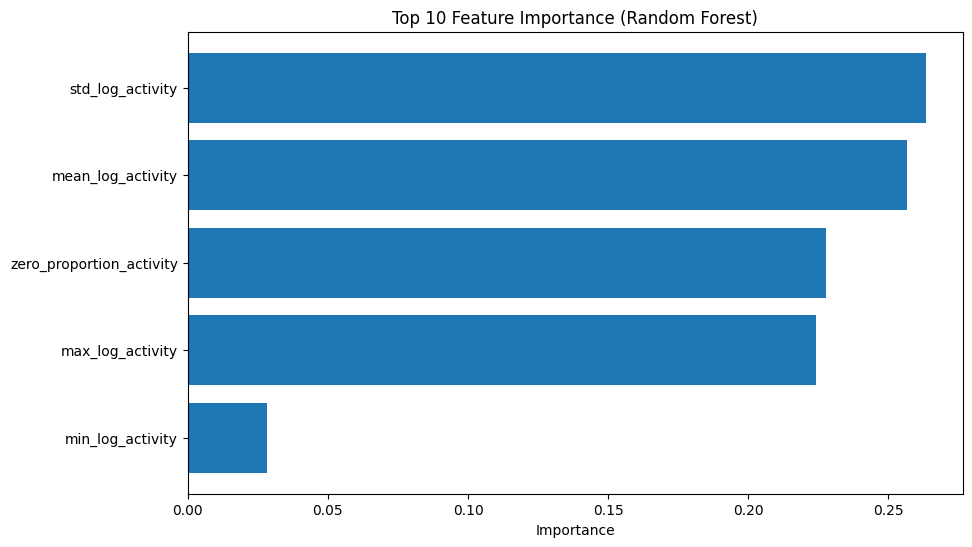

In [44]:
# Cell 16: Feature Importance Analysis
print("\n=== FEATURE IMPORTANCE ===")
print("=" * 40)

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': forest.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

In [45]:
# Cell 17: Prediction Function
def predict_depression_from_activity(features):
    """
    Predict depression status from activity features
    features: Dictionary or DataFrame with required features
    """
    # Convert to DataFrame if needed
    if isinstance(features, dict):
        features_df = pd.DataFrame([features])
    else:
        features_df = features

    # Ensure all required columns are present
    required_cols = ['mean_log_activity', 'std_log_activity',
                     'min_log_activity', 'max_log_activity',
                     'zero_proportion_activity']

    for col in required_cols:
        if col not in features_df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Get predictions from all models
    rf_pred = forest.predict(features_df)[0]
    knn_pred = knn.predict(features_df)[0]
    xgb_pred = xgb_classifier.predict(features_df)[0]

    # Reshape for LSTM
    features_lstm = features_df.values.reshape((1, 1, features_df.shape[1]))
    lstm_pred_proba = model_lstm.predict(features_lstm)[0][0]
    lstm_pred = 1 if lstm_pred_proba >= 0.5 else 0

    # Ensemble prediction
    predictions = [rf_pred, knn_pred, xgb_pred, lstm_pred]
    final_pred = 1 if sum(predictions) >= 2 else 0

    # Confidence score
    confidence = sum(predictions) / len(predictions)

    return {
        'prediction': 'Depressed' if final_pred == 1 else 'Not Depressed',
        'confidence': confidence,
        'individual_predictions': {
            'Random Forest': 'Depressed' if rf_pred == 1 else 'Not Depressed',
            'KNN': 'Depressed' if knn_pred == 1 else 'Not Depressed',
            'XGBoost': 'Depressed' if xgb_pred == 1 else 'Not Depressed',
            'LSTM': 'Depressed' if lstm_pred == 1 else 'Not Depressed'
        }
    }

# Example usage
print("\nExample Prediction:")
sample_features = {
    'mean_log_activity': 4.5,
    'std_log_activity': 2.3,
    'min_log_activity': 0.0,
    'max_log_activity': 8.1,
    'zero_proportion_activity': 150
}
result = predict_depression_from_activity(sample_features)
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2f}")


Example Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Prediction: Depressed
Confidence: 0.75


In [48]:
# Cell 18: Summary Report

# Calculate final ensemble accuracy using the predict_depression_from_activity function
final_predictions = []
for index, row in X_test.iterrows():
    # Convert row to dictionary for predict_depression_from_activity
    features_dict = row.to_dict()
    prediction_result = predict_depression_from_activity(features_dict)
    # Convert 'Depressed'/'Not Depressed' to 1/0
    final_predictions.append(1 if prediction_result['prediction'] == 'Depressed' else 0)

final_acc = accuracy_score(y_test, final_predictions)

print("\n" + "="*50)
print("DEPRESSION DETECTION SYSTEM - MOTION ACTIVITY ANALYSIS")
print("="*50)

print(f"\nDataset Statistics:")
print(f"Total samples: {len(full_df)}")
print(f"Depressed (state=1): {len(full_df[full_df['state']==1])}")
print(f"Not Depressed (state=0): {len(full_df[full_df['state']==0])}")

print(f"\nModel Performance Summary:")
print(f"{'-'*40}")
print(f"Random Forest: {rf_acc:.4f}")
print(f"K-Nearest Neighbors: {knn_acc:.4f}")
print(f"XGBoost: {xgb_acc:.4f}")
print(f"Voting Ensemble: {ensemble_acc:.4f}")
print(f"LSTM: {lstm_acc:.4f}")
print(f"Final Ensemble (All Models): {final_acc:.4f}")

print(f"\nBest Model: {'FINAL ENSEMBLE' if final_acc >= max([rf_acc, knn_acc, xgb_acc, ensemble_acc, lstm_acc]) else 'INDIVIDUAL MODEL'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━